Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

**Question 7**: Full radiation sensor experiment simulation - set up a fairly complete radiation sensor measurement and analysis simulation in stages.

**(a)**: Use the simple pulse model function from the script (page 43, function `simple_pulse`, lines 4-10) and modify it to take the full time value array as first input as well as the pulse onset number as second input parameter: `simple_pulse(time, onset, amplitude, risetime, decaytime)`.

**(b)**: Create a set of 2000 pulses of length 1000 with each entry corresponding to 1 ns sampling with the following composition: 

A fraction of 45% of all pulses should feature amplitudes, $A$, from a uniform distribution between 1 and 100. Each pulse should have a risetime of 6 ns, decay time of 200 ns and onset time of 250 ns. Then, separately, add noise to each pulse. The noise should consist of 1000 Gaussian random numbers with amplitude of $\sqrt{A}$, added to the 1000 pulse values. Store the pulses for processing at the next stage.

Another 45% of all pulses should be randomly chosen from a set of amplitudes: $(11, 16, 31, 82)$, representing monoenergetic radiation from a source. Again, add Gaussian noise to each pulse like above and add each pulse to the data store.

The final 10% of all pulses should be made up of random amplitude (between 1 and 20) damped oscillations with frequency $1/80$ ns$^{-1}$ and decay time 500 ns, i.e. not the simple pulse model, i.e. write a suitable function for this oscillation model. Call this function `oscillation(length, amplitude, freq, decaytime)` with the data array length, amplitude, frequency and decay time as arguments in that order. These oscillations would represent typical microphonics noise of sensors and are often a nuisance in real measurements. Again, add Gaussian noise to each oscillation model like above and add each output to the data store.

**(c)**: Fit all pulses in the data store and store the fitted amplitudes and, separately, the relative errors of all 4 fitted parameters. The latter should result in a 2D array of shape $(N,4)$ with $N$ the number of successfully fitted pulses, see hint below. Complicated fits really require good starting value guesses and fit parameter boundaries, both of which can be handed over to the scipy `curve_fit()` function. 

**Hint:** Remember that fits can fail and should then simply be discarded - look up and use a python try, except clause construction, i.e. error handling in python. If the fit fails then `curve_fit` will typically raise a 'ValueError' which your code can find with the 'except' keyword and move on to the next fit, i.e. discard that failed fit. You should expect some failed fits, resulting in $N<2000$.

**(d)**: Draw a first plot of amplitudes against onset relative error, with appropriate axis labels, and define a selection cut (likely on too small amplitudes) for a population of fit results which should represent well-fit, reliable pulse amplitudes. Draw a histogram plot of this select population of amplitudes. This histogram should show amplitude peaks corresponding to the radiation source and some background.

**(e)**: Fit and draw (on the histogram) the radiation peaks as Gaussian curves on a background which should be flat and create a final plot of fitted peak width against fitted amplitude for the fitted peaks. This represents the energy resolution response function of your hypothetical radiation sensor.


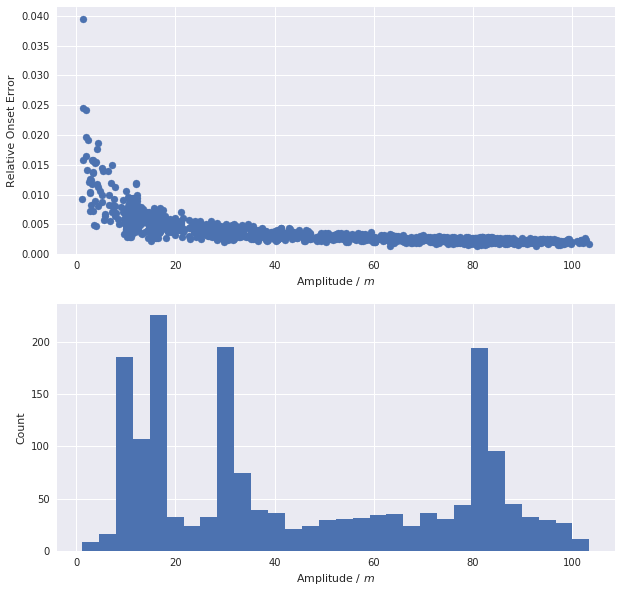

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

np.seterr("raise")
num_pulses = 2000
time_values = np.linspace(0, 1000, 1000)
pulse_kwargs = {"onset": 250, "risetime": 6, "decaytime": 200}
osc_kwargs = {"freq": 1 / 80, "decaytime": 50}
pulse_p0 = (
    pulse_kwargs["onset"],
    50,
    pulse_kwargs["risetime"],
    pulse_kwargs["decaytime"],
)
osc_p0 = (1000, 11, osc_kwargs["freq"], osc_kwargs["decaytime"])


def simple_pulse(time, onset, amplitude, risetime, decaytime):
    pulse = np.exp(-(time - onset) / risetime) - np.exp(-(time - onset) / decaytime)
    pulse[np.where(time < onset)] = 0
    smooth = -amplitude * pulse
    return smooth


def oscillation_sensible(time, amplitude, freq, decaytime):
    return amplitude * np.exp(-time / decaytime) * np.sin(2 * np.pi * freq * time)


def oscillation(length, amplitude, freq, decaytime):
    time = np.linspace(0, length, length)
    return oscillation_sensible(time, amplitude, freq, decaytime)


def check(*args):
    for arg in args:
        if np.nan in arg or np.inf in arg:
            return False
    return True


signal_data = []
for i in range(num_pulses):
    if i <= int(num_pulses * 0.45):
        amp = np.random.uniform(1, 101)
        pulse = simple_pulse(time_values, amplitude=amp, **pulse_kwargs)
    elif i > int(num_pulses * 0.45) and i <= int(num_pulses * 0.9):
        amp = np.random.choice((11, 16, 31, 82))
        pulse = simple_pulse(time_values, amplitude=amp, **pulse_kwargs)
    else:
        amp = np.random.uniform(1, 21)
        pulse = oscillation_sensible(time_values, amp, **osc_kwargs)
    pulse += np.random.normal(scale=np.sqrt(amp), size=len(time_values))
    signal_data.append(pulse)

amplitudes = []
errors = []

for index, signal in enumerate(signal_data):
    try:
        if index <= int(0.9 * num_pulses):
            popt, pcov = curve_fit(simple_pulse, time_values, signal, pulse_p0)
            errs = np.sqrt(np.diag(pcov)) / popt
            if check(popt, pcov):
                errors.append(errs)
                amplitudes.append(popt[1])
        else:
            continue
            popt, pcov = curve_fit(oscillation, time_values, signal, osc_p0)
            errs = np.sqrt(np.diag(pcov)) / popt
            if check(popt, pcov):
                errors.append(errs)
                amplitudes.append(popt[1])
    except FloatingPointError:
        pass
    except OptimizeWarning:
        pass

amplitudes = np.array(amplitudes)
errors = np.array(errors)
onset_errors = errors[:, 0]
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
ax1.scatter(amplitudes, onset_errors)
ax1.set_xlabel("Amplitude / $m$")
ax1.set_ylabel("Relative Onset Error")
ax1.set_ylim(0, max(onset_errors) * 1.05)
ax2.hist(amplitudes[onset_errors <= 0.010], bins=30)
ax2.set_xlabel("Amplitude / $m$")
ax2.set_ylabel("Count")
plt.show()

In [2]:
# Test cell
# test simple_pulse function
rt = 6.0
dt = 200.0
l = 1000
amp = 10.0
t = np.linspace(0, l, l + 1)
on = 0.25 * l  # start 25% into the length

data = simple_pulse(t, on, amp, rt, dt)
assert np.argmax(data) == 272, "wrong location of pulse maximum."

In [3]:
# Test cell
# test oscillation function
l = 1000
oscdecay = 500
oscfreq = 1.0 / 80.0
amp = 10
data = oscillation(l, amp, oscfreq, oscdecay)
assert np.argmax(data) == 20 and np.argmin(data) == 60, "wrong max and min locations."
assert (
    np.max(data) > 9.5 and np.max(data) < 9.7
), "wrong maximum amplitude for oscillation."

### Tests 3 marks; Style 1 mark; Plots - 6 marks